In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

def load_data(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, 1:].values  
    Y = data.iloc[:, 0].values   
    return X, Y

def preprocess_data(X, Y):
    # Normalize features
    X = X / 255.0
    # One-hot encode labels
    Y_encoded = np.eye(np.max(Y) + 1)[Y]
    
    return X.T, Y_encoded.T

class NeuralNetwork:
    
    def __init__(self, input_size, hidden_size, output_size):
        # Use He initialization for weights
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((output_size, 1))
    
    def forward_propagation(self, X, keep_prob):
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = np.maximum(0, self.Z1)

        # Dropout for the hidden layer
        self.dropout_mask1 = (np.random.rand(*self.A1.shape) < keep_prob) / keep_prob
        self.A1 *= self.dropout_mask1

        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2
    
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    
    def train(self, X_train, Y_train, X_test, Y_test, iterations, initial_learning_rate, batch_size, lambda_, keep_prob, decay_rate=0.96, decay_step=100):
        m_train = X_train.shape[1]
        m_test = X_test.shape[1]
        train_costs = []
        test_costs = []
        train_accuracies = []
        test_accuracies = []
        learning_rates = []

        learning_rate = initial_learning_rate

        for i in range(iterations):
            # Update learning rate using exponential decay
            learning_rate = initial_learning_rate * decay_rate**(i // decay_step)
            learning_rates.append(learning_rate)

            permutation = np.random.permutation(m_train)
            X_shuffled = X_train[:, permutation]
            Y_shuffled = Y_train[:, permutation]

            epoch_cost = 0

            for j in range(0, m_train, batch_size):
                X_batch = X_shuffled[:, j:j+batch_size]
                Y_batch = Y_shuffled[:, j:j+batch_size]

                A2 = self.forward_propagation(X_batch, keep_prob)
                cost = self.compute_cost(A2, Y_batch, lambda_)
                dW1, db1, dW2, db2 = self.back_propagation(X_batch, Y_batch, A2, keep_prob)
                self.W1 -= learning_rate * dW1
                self.b1 -= learning_rate * db1
                self.W2 -= learning_rate * dW2
                self.b2 -= learning_rate * db2

                epoch_cost += cost * X_batch.shape[1]

            epoch_cost /= m_train
            train_costs.append(epoch_cost)

            # Compute test cost
            A2_test = self.forward_propagation(X_test, keep_prob)
            test_cost = self.compute_cost(A2_test, Y_test, lambda_)
            test_costs.append(test_cost)

            if i % 10 == 0:
                train_accuracy = self.evaluate(X_train, Y_train, keep_prob)
                test_accuracy = self.evaluate(X_test, Y_test, keep_prob)
                train_accuracies.append(train_accuracy * 100)
                test_accuracies.append(test_accuracy * 100)

                print(f"Epoch {i} | Training Accuracy = {train_accuracy * 100:.5f}% | Test Accuracy = {test_accuracy * 100:.5f}%\n")

        return train_costs, test_costs, train_accuracies, test_accuracies, learning_rates



    def compute_cost(self, A2, Y, lambda_):
        m = Y.shape[1]
        cross_entropy_cost = -np.sum(Y * np.log(A2 + 1e-8)) / m
        L2_regularization_cost = (lambda_ / (2 * m)) * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        cost = cross_entropy_cost + L2_regularization_cost
        return cost
    
    def back_propagation(self, X, Y, A2, keep_prob):
        m = X.shape[1]
        dZ2 = A2 - Y
        dW2 = (1 / m) * np.dot(dZ2, self.A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
        dZ1 = np.dot(self.W2.T, dZ2) * (self.A1 > 0)

        dZ1 *= self.dropout_mask1

        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
        return dW1, db1, dW2, db2

    def evaluate(self, X, Y, keep_prob=1.0):
        A2 = self.forward_propagation(X, keep_prob)
        predictions = np.argmax(A2, axis=0)
        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels)
        return accuracy

# Step 4: Save and Load Model
def save_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


#Load and preprocess the data, Adjust accoridngly to dataset
X_train, Y_train = preprocess_data(*load_data('mnist_train.csv'))
X_test, Y_test = preprocess_data(*load_data('mnist_test.csv'))

#Parameters
input_size = X_train.shape[0]
hidden_size = 128
output_size = 10
iterations = 300
initial_learning_rate = 0.01
batch_size = 64  

lambda_ = 0.01
#keep 80% of data
keep_prob = 0.8 

model = NeuralNetwork(input_size, hidden_size, output_size)
train_costs, test_costs, train_accuracies, test_accuracies, learning_rates = model.train(
    X_train, Y_train, X_test, Y_test, iterations, initial_learning_rate, batch_size, lambda_, keep_prob)

#Save the model
save_model(model, 'neural_network_model.pkl')

Epoch 0 | Training Accuracy = 84.27307% | Test Accuracy = 85.22852%

Epoch 10 | Training Accuracy = 93.19489% | Test Accuracy = 93.35934%

Epoch 20 | Training Accuracy = 94.96658% | Test Accuracy = 94.75948%

Epoch 30 | Training Accuracy = 95.83993% | Test Accuracy = 95.60956%

Epoch 40 | Training Accuracy = 96.45327% | Test Accuracy = 95.94959%

Epoch 50 | Training Accuracy = 96.76328% | Test Accuracy = 96.44964%

Epoch 60 | Training Accuracy = 97.21495% | Test Accuracy = 96.69967%

Epoch 70 | Training Accuracy = 97.34829% | Test Accuracy = 96.63966%

Epoch 80 | Training Accuracy = 97.60163% | Test Accuracy = 96.75968%

Epoch 90 | Training Accuracy = 97.68329% | Test Accuracy = 96.88969%

Epoch 100 | Training Accuracy = 97.87996% | Test Accuracy = 97.09971%

Epoch 110 | Training Accuracy = 97.93997% | Test Accuracy = 97.14971%

Epoch 120 | Training Accuracy = 98.16664% | Test Accuracy = 97.31973%

Epoch 130 | Training Accuracy = 98.17164% | Test Accuracy = 97.39974%

Epoch 140 | Train

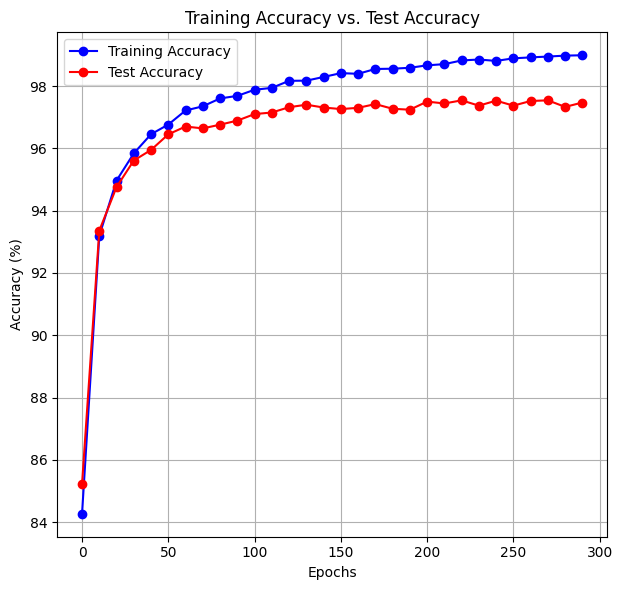

In [3]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(0, len(train_accuracies) * 10, 10), train_accuracies, label='Training Accuracy', color='blue', marker = "o")
plt.plot(range(0, len(test_accuracies) * 10, 10), test_accuracies, label='Test Accuracy', color='red', marker = "o")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs. Test Accuracy')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

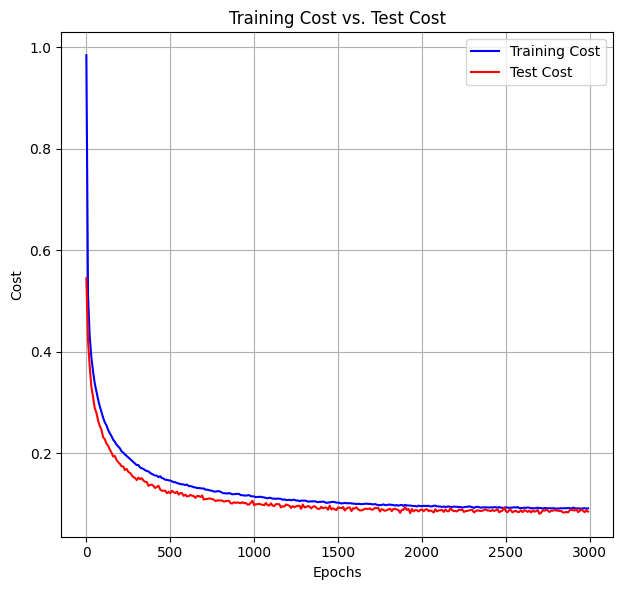

In [4]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(0, len(train_costs)*10, 10), train_costs, label='Training Cost', color='blue')
plt.plot(range(0, len(test_costs)*10, 10), test_costs, label='Test Cost', color='red')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training Cost vs. Test Cost')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

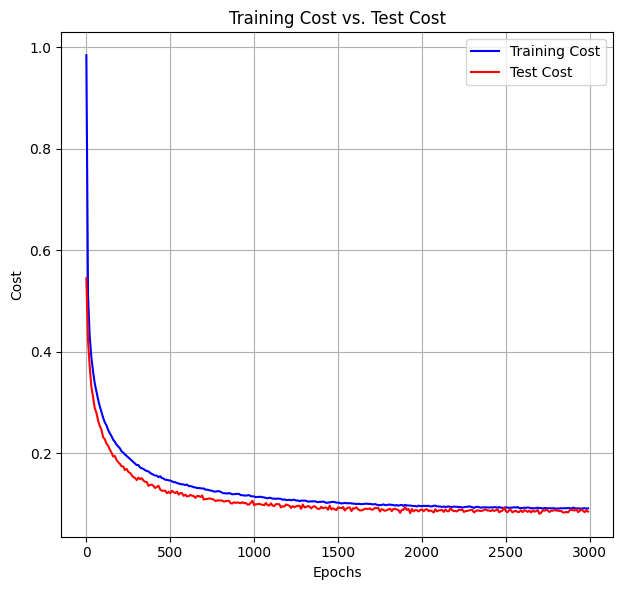

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(0, len(train_costs)*10, 10), train_costs, label='Training Cost', color='blue')
plt.plot(range(0, len(test_costs)*10, 10), test_costs, label='Test Cost', color='red')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training Cost vs. Test Cost')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()